<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments-Flower/blob/main/Endpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **MODELLO CENTRALIZZATO SU ENDPOINT 1:**



### imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

In [3]:
# Check GPU availability
if tf.test.gpu_device_name():
    print(f"GPU disponibile: {tf.test.gpu_device_name()}")
else:
    print("GPU non disponibile. L'esecuzione potrebbe essere più lenta.")

GPU non disponibile. L'esecuzione potrebbe essere più lenta.


### Data in the book way

In [ ]:
from datasets import load_dataset
df = load_dataset("anastasiafrosted/globus", download_mode="force_redownload")

endpoint1_train.csv:   0%|          | 0.00/481k [00:00<?, ?B/s]

endpoint1_test.csv:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2307 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/122 [00:00<?, ? examples/s]

In [ ]:
train = pd.DataFrame(df['train'])
train['timestamp'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d:%H')

training_set = train[train['timestamp'] < pd.Timestamp('2023-06-10 20:00')]
val_set = train[train['timestamp'] > pd.Timestamp('2023-06-10 20:00')]

test_set = pd.DataFrame(df['test'])


# drop some columns
timestamps = test_set[['timestamp']].to_numpy()
training_set = training_set.drop(["timestamp", "endpoint_uuid"], axis=1)
val_set = val_set.drop(["timestamp", "endpoint_uuid"], axis=1)
test_set = test_set.drop(["timestamp", "endpoint_uuid"], axis=1)

# get targets
y_train = training_set[['avg_execution_time', 'avg_scheduling_time']]  # Target: 2 features
x_train = training_set.drop(columns=['avg_execution_time', 'avg_scheduling_time'])  # Input: 12 features

y_val = val_set[['avg_execution_time', 'avg_scheduling_time']]  # Target: 2 features
x_val = val_set.drop(columns=['avg_execution_time', 'avg_scheduling_time'])  # Input: 12 features

y_test = test_set[['avg_execution_time', 'avg_scheduling_time']]  # Target: 2 features
x_test = test_set.drop(columns=['avg_execution_time', 'avg_scheduling_time'])  # Input: 12 features

In [ ]:
seq_len = 7

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_train,
    targets=np.array([y_train[i:i + seq_len] for i in range(len(y_train) - seq_len + 1)]),
    sequence_length=seq_len,
    batch_size=8,
    shuffle=True)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_val,
    targets=np.array([y_val[i:i + seq_len] for i in range(len(y_val) - seq_len + 1)]),
    sequence_length=seq_len,
    batch_size=8,
    shuffle=True)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_test,
    targets=np.array([y_test[i:i + seq_len] for i in range(len(y_test) - seq_len + 1)]),
    sequence_length=seq_len,
    batch_size=8,
    shuffle=False
)

print(test_ds)
# Inspect individual batches
for batch in test_ds.take(1):  # Take one batch for demonstration
    inputs, targets = batch
    print(f"Inputs Shape: {inputs.shape}")   # Should be [batch_size, seq_len, 11]
    print(f"Targets Shape: {targets.shape}")  # Should be [batch_size, 2]


<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 11), dtype=tf.float64, name=None), TensorSpec(shape=(None, 7, 2), dtype=tf.float64, name=None))>
Inputs Shape: (8, 7, 11)
Targets Shape: (8, 7, 2)


 ### Linear

In [ ]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=[seq_len, x_train.shape[1]]) # Shape is: (8, 7, 11)
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=5000,
    decay_rate=1
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
linear_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = linear_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping_cb])

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5039 - mae: 0.7926 - val_loss: 0.1317 - val_mae: 0.1635
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - mae: 0.0473 - val_loss: 0.1315 - val_mae: 0.1567
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0198 - mae: 0.0469 - val_loss: 0.1318 - val_mae: 0.1728
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - mae: 0.0488 - val_loss: 0.1316 - val_mae: 0.1656
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - mae: 0.0507 - val_loss: 0.1317 - val_mae: 0.1774
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - mae: 0.0509 - val_loss: 0.1312 - val_mae: 0.1596
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - mae: 0.0489 - val_loss: 0.1321 - val_mae: 0.1863
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0198 - mae: 0.0531 - val_loss: 0.1311 - val_mae: 0.1585
Epoch 9/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

In [ ]:
# Evaluate the model on the test set
loss, mae = linear_model.evaluate(test_ds)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict on the test set
predictions = linear_model.predict(test_ds)
#print(f"Predictions:\n{predictions[:, 0, :]}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0262e-04 - mae: 0.0162 
Test Loss: 0.0005649762460961938, Test MAE: 0.018144311383366585
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


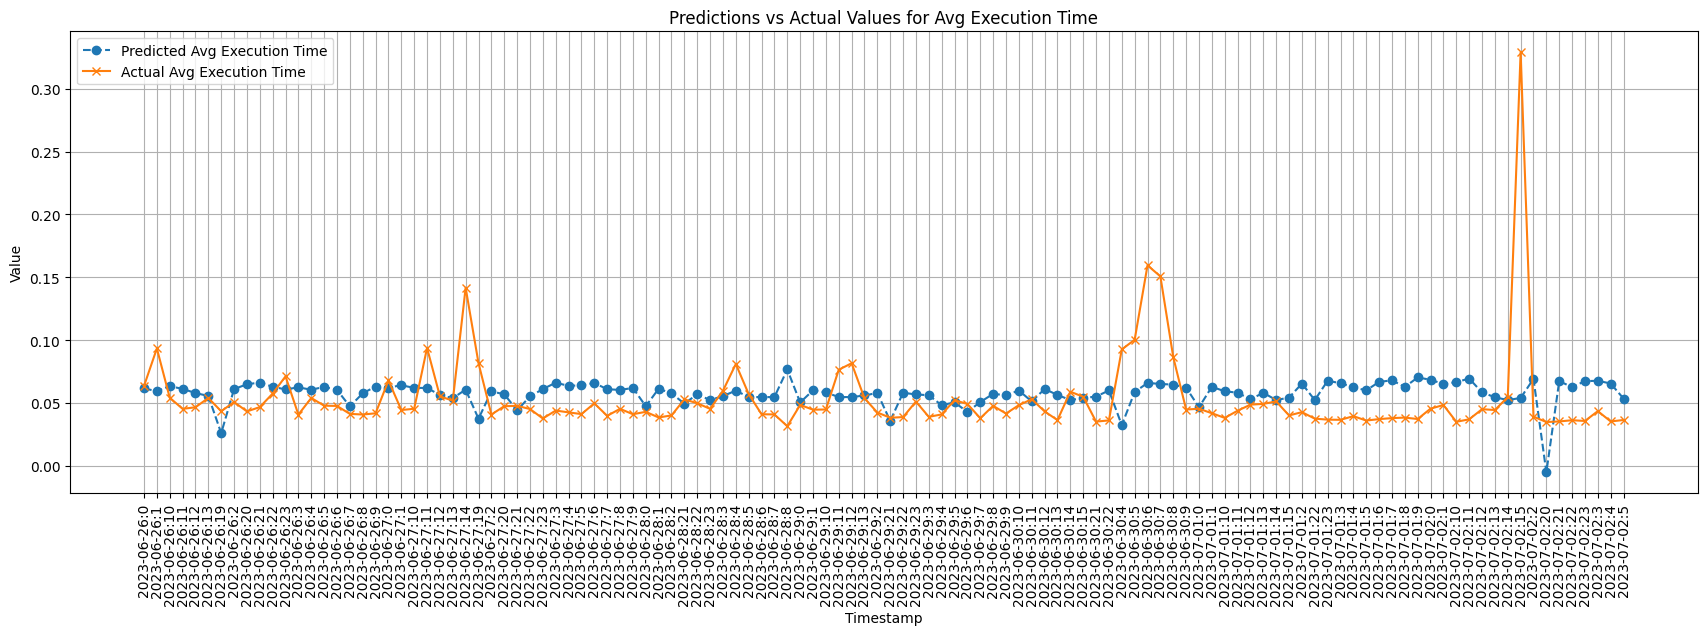

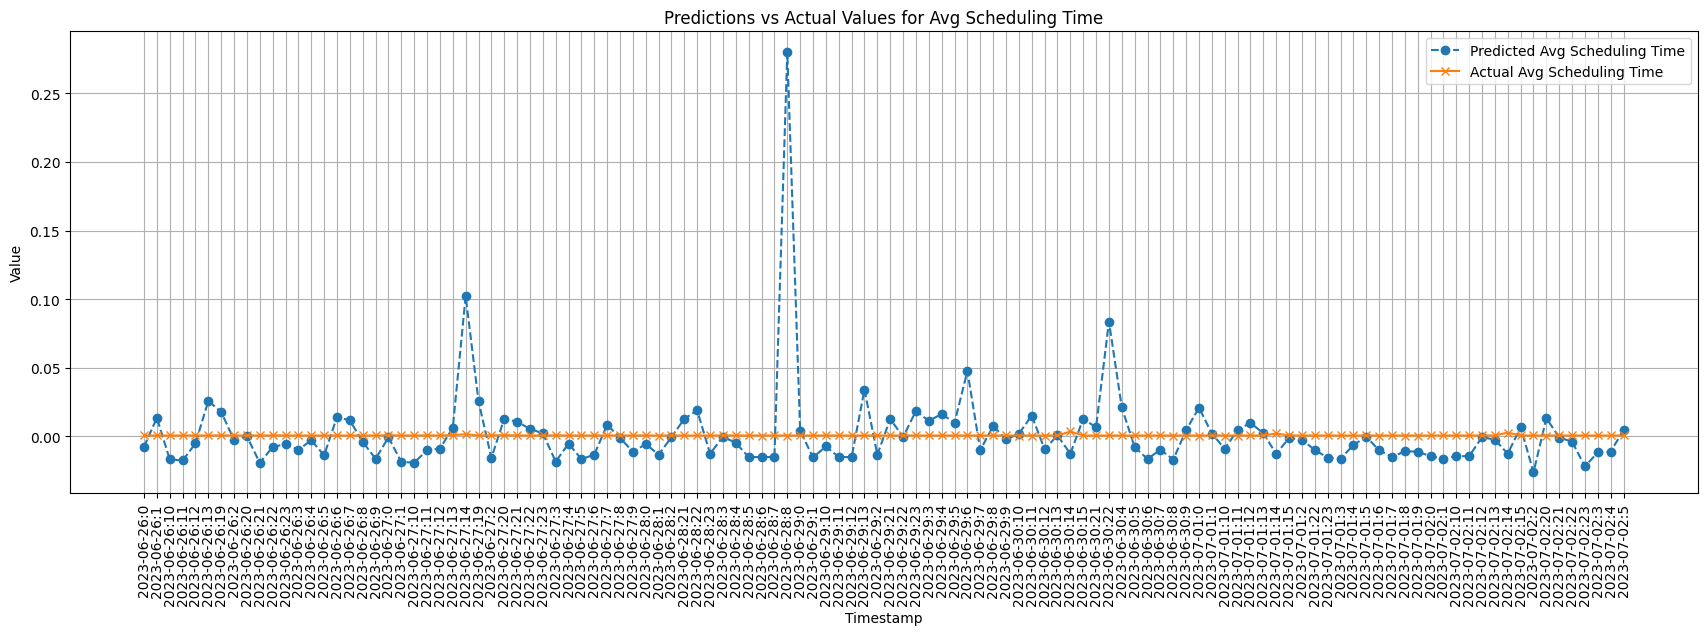

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract actual values from the test dataset
actuals = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Extract the first value of each sequence for predictions and actuals
predicted_first_values = predictions[:, 0, :]  # Shape: [num_sequences, num_targets]
actual_first_values = actuals[:, 0, :]         # Shape: [num_sequences, num_targets]

# Extract the timestamps for the first value of each sequence
sequence_timestamps = timestamps[:len(predicted_first_values)]

# Plot for Target Feature 1
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:, 0], predicted_first_values[:, 0], label='Predicted Avg Execution Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:, 0], actual_first_values[:, 0], label='Actual Avg Execution Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Execution Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

# Plot for Target Feature 2
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:, 0], predicted_first_values[:, 1], label='Predicted Avg Scheduling Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:, 0], actual_first_values[:, 1], label='Actual Avg Scheduling Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Scheduling Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()


### RNN

In [ ]:
# Define the model
rnn_model = tf.keras.Sequential([
    # SimpleRNN Layer
    tf.keras.layers.SimpleRNN(7, return_sequences=True, input_shape=(7, 11)),
    # Output Dense Layer
    tf.keras.layers.Dense(2)  # Output layer for 2 targets per timestep
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
rnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"])
history = rnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping_cb])

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0339 - mae: 0.1339 - val_loss: 0.1287 - val_mae: 0.1460
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - mae: 0.0339 - val_loss: 0.1291 - val_mae: 0.1494
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180 - mae: 0.0327 - val_loss: 0.1293 - val_mae: 0.1504
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - mae: 0.0332 - val_loss: 0.1293 - val_mae: 0.1464
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0179 - mae: 0.0321 - val_loss: 0.1293 - val_mae: 0.1494
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0174 - mae: 0.0318 - val_loss: 0.1293 - val_mae: 0.1512
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0183 - mae: 0.0328 - val_loss: 0.1293 - val_mae: 0.1499
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0189 - mae: 0.0331 - val_loss: 0.1293 - val_mae: 0.1483
Epoch 9/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

In [ ]:
# Evaluate the model
test_loss, test_mae = rnn_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
predictions = rnn_model.predict(test_ds)
print(f"Predictions Shape: {predictions.shape}")  # Should be (8, 7, 2)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4495e-04 - mae: 0.0083 
Test Loss: 0.00029836688190698624, Test MAE: 0.010267957113683224
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions Shape: (116, 7, 2)


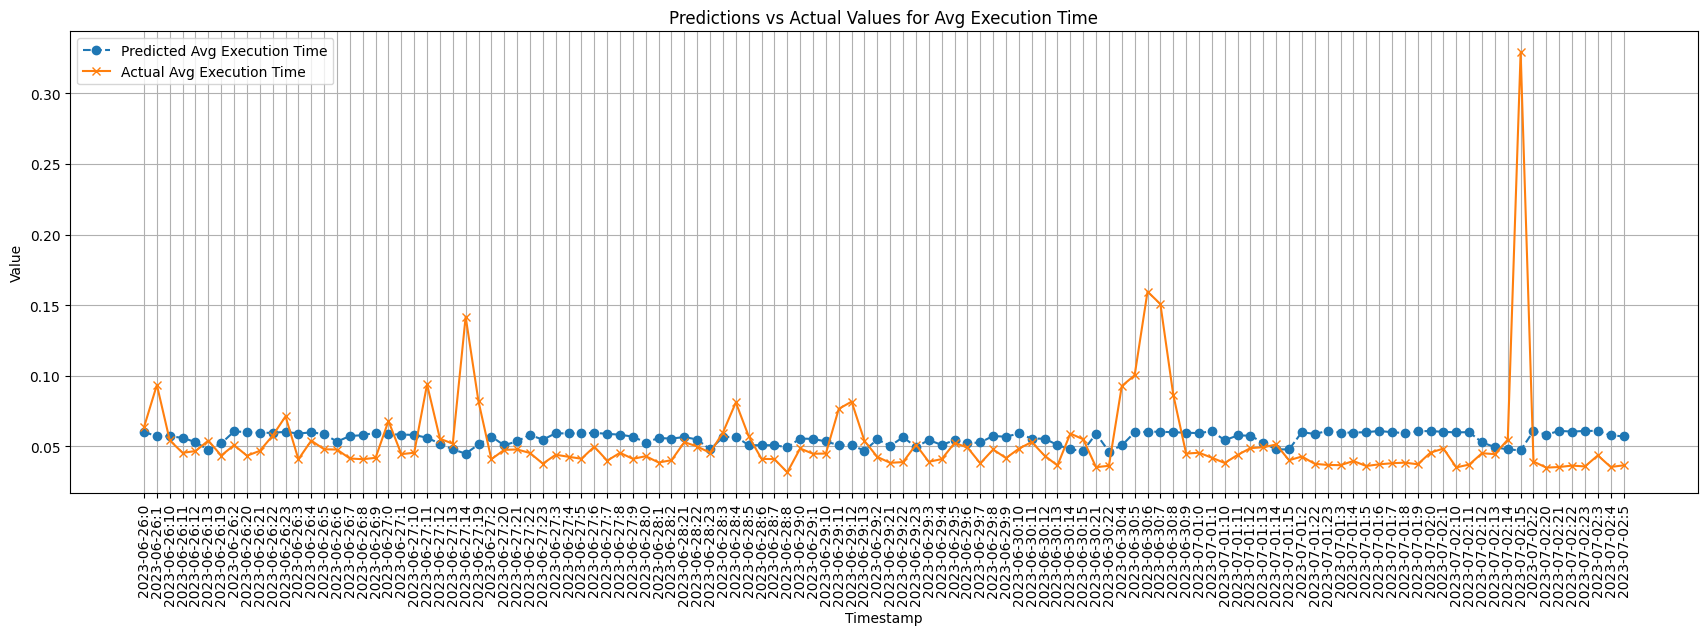

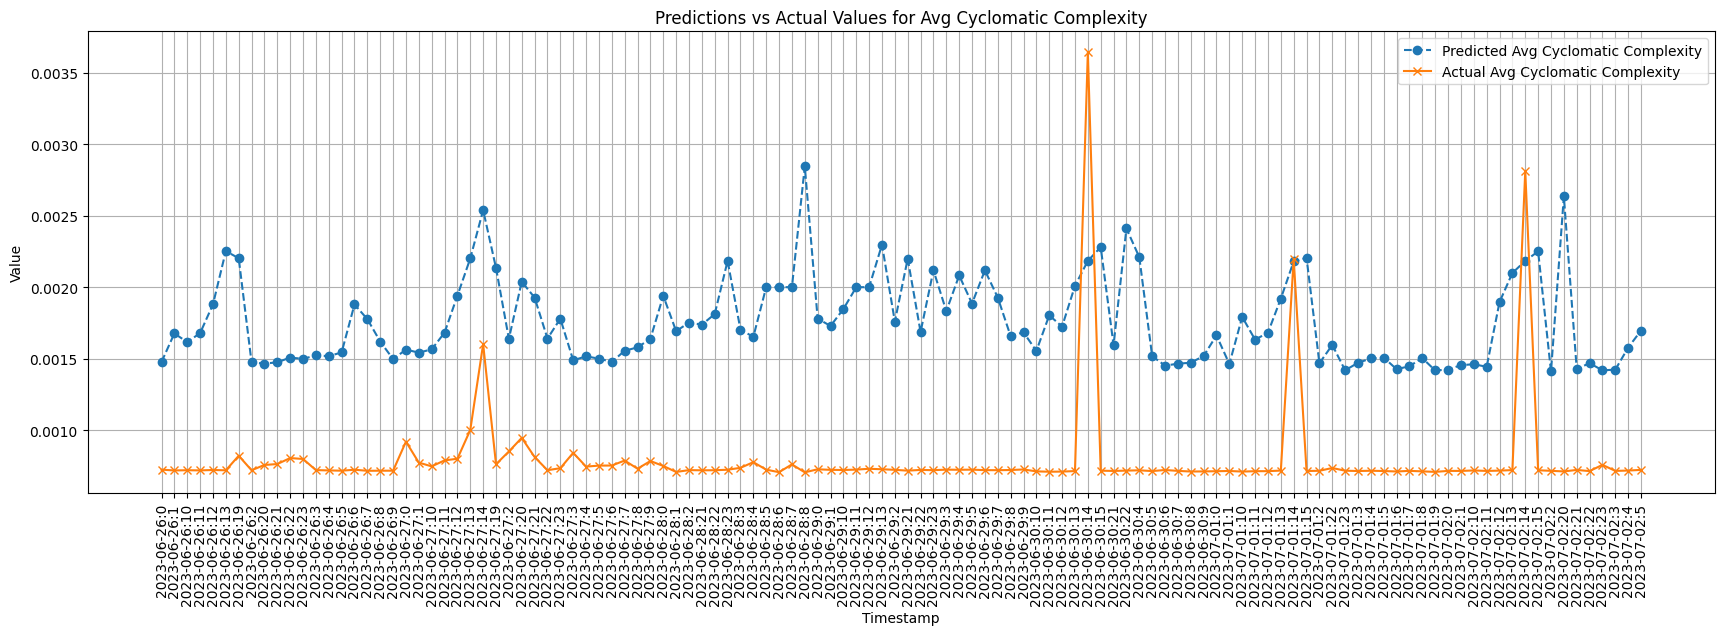

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract actual values from the test dataset
actuals = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Extract the first value of each sequence for predictions and actuals
predicted_first_values = predictions[:, 0, :]  # Shape: [num_sequences, num_targets]
actual_first_values = actuals[:, 0, :]         # Shape: [num_sequences, num_targets]

# Extract the timestamps for the first value of each sequence
sequence_timestamps = timestamps[:len(predicted_first_values)]

# Plot for Target Feature 1
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 0], label='Predicted Avg Execution Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 0], label='Actual Avg Execution Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Execution Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

# Plot for Target Feature 2
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 1], label='Predicted Avg Cyclomatic Complexity', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 1], label='Actual Avg Cyclomatic Complexity', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Cyclomatic Complexity")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()


### CNN

In [ ]:
# Define the model
cnn_model = tf.keras.Sequential([
    # SimpleRNN Layer
    tf.keras.layers.Conv1D(filters=2, kernel_size=4, strides=7, activation="relu"),
    tf.keras.layers.GRU(7, return_sequences=True),
    # Output Dense Layer
    tf.keras.layers.Dense(2)  # Output layer for 2 targets per timestep
])

In [ ]:
cnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"])
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping_cb])

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0606 - mae: 0.1584 - val_loss: 0.1293 - val_mae: 0.1485
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - mae: 0.0318 - val_loss: 0.1293 - val_mae: 0.1494
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - mae: 0.0316 - val_loss: 0.1293 - val_mae: 0.1496
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - mae: 0.0320 - val_loss: 0.1293 - val_mae: 0.1488
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0188 - mae: 0.0327 - val_loss: 0.1293 - val_mae: 0.1498
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0182 - mae: 0.0323 - val_loss: 0.1293 - val_mae: 0.1487
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180 - mae: 0.0319 - val_loss: 0.1293 - val_mae: 0.1498
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0178 - mae: 0.0318 - val_loss: 0.1293 - val_mae: 0.1517
Epoch 9/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

In [ ]:
# Evaluate the model
test_loss, test_mae = cnn_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
predictions = cnn_model.predict(test_ds)
print(f"Predictions Shape: {predictions.shape}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5989e-04 - mae: 0.0110 
Test Loss: 0.00030851454357616603, Test MAE: 0.01297591533511877
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predictions Shape: (116, 1, 2)


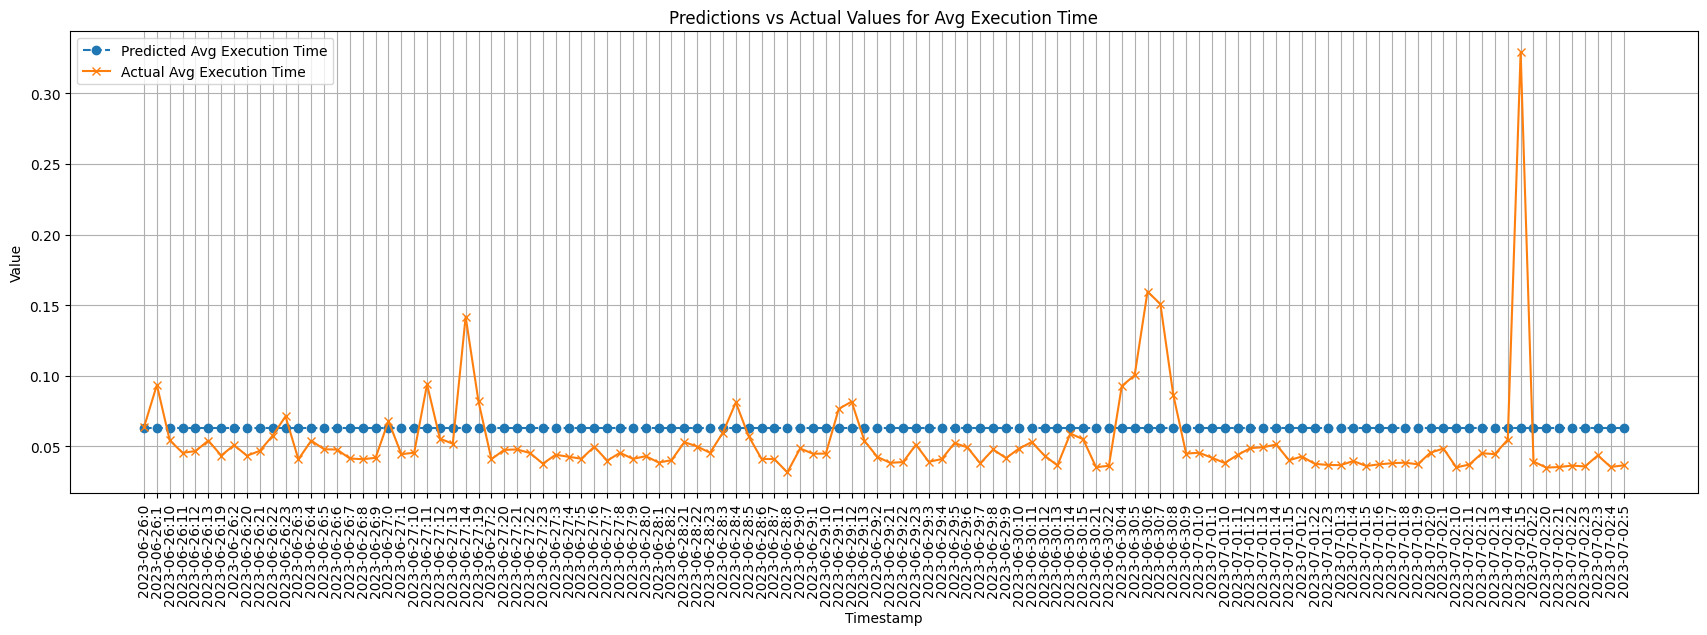

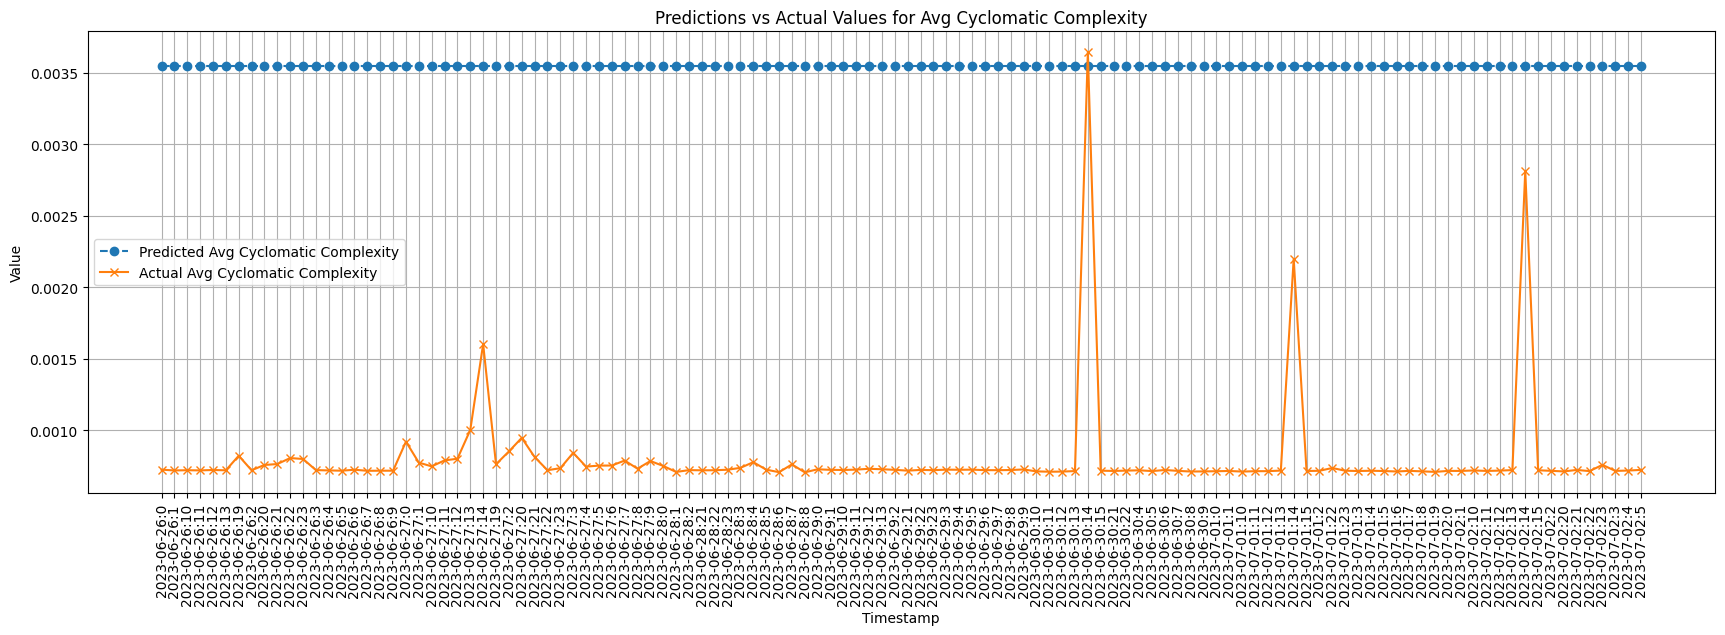

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract actual values from the test dataset
actuals = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Extract the first value of each sequence for predictions and actuals
predicted_first_values = predictions[:, 0, :]  # Shape: [num_sequences, num_targets]
actual_first_values = actuals[:, 0, :]         # Shape: [num_sequences, num_targets]

# Extract the timestamps for the first value of each sequence
sequence_timestamps = timestamps[:len(predicted_first_values)]

# Plot for Target Feature 1
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 0], label='Predicted Avg Execution Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 0], label='Actual Avg Execution Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Execution Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

# Plot for Target Feature 2
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 1], label='Predicted Avg Cyclomatic Complexity', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 1], label='Actual Avg Cyclomatic Complexity', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Cyclomatic Complexity")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

### LSTM

In [ ]:
from datasets import load_dataset
dataset = load_dataset("anastasiafrosted/sequenced_endpoint_0", download_mode="force_redownload")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/851 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/493495 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/34759 [00:00<?, ? examples/s]

In [ ]:
training_set = pd.DataFrame(dataset['train'])
test_set = pd.DataFrame(dataset['test'])

In [ ]:
x_train = training_set.copy()
x_test = test_set.copy()

# Pop two target features into y_train and y_test
y_train = x_train[['avg_total_execution_time_target', 'avg_system_processing_time_target']]
y_test = x_test[['avg_total_execution_time_target', 'avg_system_processing_time_target']]

# Save aside timestamps
x_train_timestamps = x_train['timestamp_seq']
x_test_timestamps = x_test['timestamp_seq']

y_train_timestamps = x_train['timestamp_target']
y_test_timestamps = x_test['timestamp_target']

# Drop the targets from predictors
x_train = x_train.drop(['avg_total_execution_time_target', 'avg_system_processing_time_target', 'timestamp_seq', 'timestamp_target'], axis=1)
x_test = x_test.drop(['avg_total_execution_time_target', 'avg_system_processing_time_target', 'timestamp_seq', 'timestamp_target'], axis=1)

columns = x_train.columns.tolist()
targets = ['avg_total_execution_time_target', 'avg_system_processing_time_target']

In [ ]:
# Extract the first value of each list
timestamps = np.array([timestamps[0] for timestamps in x_test_timestamps])
print(len(timestamps))
print(timestamps)

34759
[datetime.datetime(2023, 6, 26, 0, 0, 17)
 datetime.datetime(2023, 6, 26, 0, 0, 21)
 datetime.datetime(2023, 6, 26, 0, 0, 31) ...
 datetime.datetime(2023, 7, 3, 1, 58, 17)
 datetime.datetime(2023, 7, 3, 1, 58, 20)
 datetime.datetime(2023, 7, 3, 1, 58, 28)]


In [ ]:
# Convert each column to a 2D NumPy array (samples x timesteps)
x_train_as_arrays = [np.array(x_train[col].to_list()) for col in columns]
x_test_as_arrays = [np.array(x_test[col].to_list()) for col in columns]

y_train_as_arrays = [np.array(y_train[col].to_list()) for col in targets]
y_test_as_arrays = [np.array(y_test[col].to_list()) for col in targets]

In [ ]:
# Stack columns to create a 3D array (samples, timesteps, features)
x_train = np.stack(x_train_as_arrays, axis=-1)
x_test = np.stack(x_test_as_arrays, axis=-1)

y_train = np.stack(y_train_as_arrays, axis=-1)
y_test = np.stack(y_test_as_arrays, axis=-1)

# Verify the shape of the final 3D array
print(f"x_train shape: {x_train.shape}")  # Expected: (104837, timesteps, 14)
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (493495, 7, 5)
x_test shape: (34759, 7, 5)
y_train shape: (493495, 7, 2)
y_test shape: (34759, 7, 2)


In [ ]:
# Class for the LSTM model
class Lstm:
    def __init__(self, learning_rate, sequence_length, num_features, dropout_rate=0.2):
        self.learning_rate = learning_rate
        self.sequence_length = sequence_length  # Number of timesteps in each sequence
        self.num_features = num_features  # Number of features per timestep
        self.dropout_rate = dropout_rate

        # Define the LSTM-based model
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.sequence_length, self.num_features)),  # Input shape for LSTM
            tf.keras.layers.LSTM(
                15,
                activation='relu',
                return_sequences=True,
                #kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 regularization
                #recurrent_dropout=self.dropout_rate  # Recurrent Dropout
            ),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation='linear'))  # Final output layer for each timestep
        ])

        # Define the loss function and optimizer
        self.loss_function = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def compile(self):
        # Compile the model with optimizer, loss, and additional metrics
        self.model.compile(optimizer=self.optimizer, loss=self.loss_function,
                           metrics=["cosine_similarity", tf.keras.metrics.MeanAbsoluteError()])

    def get_model(self):
        return self.model


In [ ]:
# Usage example
learning_rate = 0.001
sequence_length = 7  # Number of timesteps in each sequence
num_features = 5 # 11  # Number of features per timestep

# Instantiate and compile the model
lstm_model = Lstm(learning_rate, sequence_length, num_features)
lstm_model.compile()

# Summary of the model
print(lstm_model.get_model().summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 15)               │           1,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 7, 2)                │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,292 (5.05 KB)

 Trainable params: 1,292 (5.05 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
history = lstm_model.get_model().fit(
    x_train, y_train,
    epochs=5,  # Adjust epochs as needed
    batch_size=7,  # Batch size for training
    validation_split=0.2  # Use 20% of the data for validation
)

Epoch 1/5
56400/56400 ━━━━━━━━━━━━━━━━━━━━ 314s 6ms/step - cosine_similarity: 0.9645 - loss: 0.7505 - mean_absolute_error: 0.0750 - val_cosine_similarity: 0.9814 - val_loss: 2.4610 - val_mean_absolute_error: 0.0762
Epoch 2/5
56400/56400 ━━━━━━━━━━━━━━━━━━━━ 372s 6ms/step - cosine_similarity: 0.9662 - loss: 0.7728 - mean_absolute_error: 0.0749 - val_cosine_similarity: 0.9799 - val_loss: 2.4660 - val_mean_absolute_error: 0.0781
Epoch 3/5
56400/56400 ━━━━━━━━━━━━━━━━━━━━ 319s 5ms/step - cosine_similarity: 0.9682 - loss: 0.5090 - mean_absolute_error: 0.0689 - val_cosine_similarity: 0.9829 - val_loss: 2.4425 - val_mean_absolute_error: 0.0972
Epoch 4/5
56400/56400 ━━━━━━━━━━━━━━━━━━━━ 316s 6ms/step - cosine_similarity: 0.9663 - loss: 0.7421 - mean_absolute_error: 0.0747 - val_cosine_similarity: 0.9820 - val_loss: 2.4468 - val_mean_absolute_error: 0.0811
Epoch 5/5
56400/56400 ━━━━━━━━━━━━━━━━━━━━ 321s 6ms/step - cosine_similarity: 0.9694 - loss: 0.7423 - mean_absolute_error: 0.0735 - val_cosi

#### graph loss

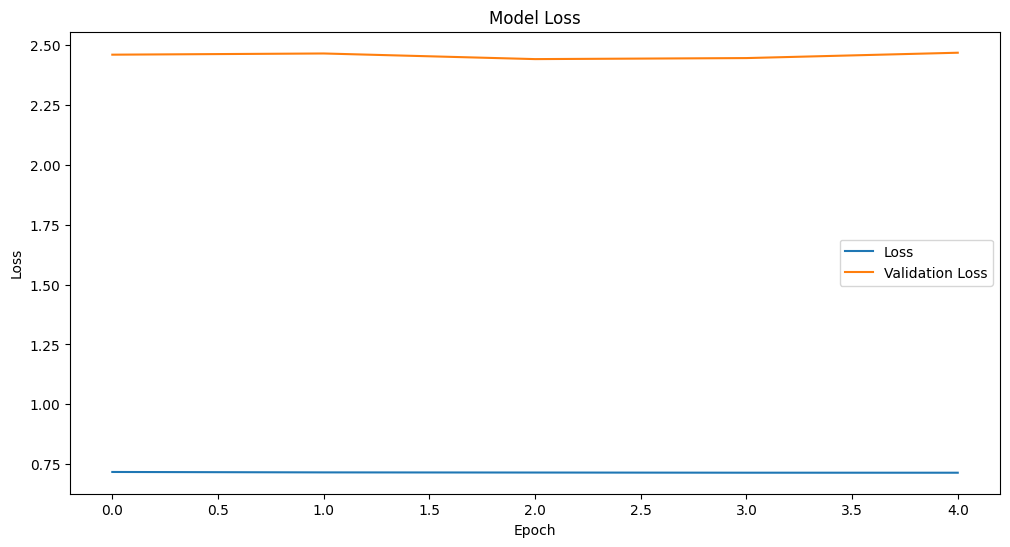

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluation

In [ ]:
# Evaluate the model on test data
test_loss, *test_metrics = lstm_model.get_model().evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
for i, metric in enumerate(test_metrics):
    print(f"Test Metric {i+1}: {metric}")

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - cosine_similarity: 0.9814 - loss: 0.0034 - mean_absolute_error: 0.0369
Test Loss: 0.006386830937117338
Test Metric 1: 0.9811088442802429
Test Metric 2: 0.037685297429561615


#### Prediction

In [ ]:
# Generate predictions
y_pred = lstm_model.get_model().predict(x_test, verbose=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"First prediction: {y_pred[0]}")


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Predictions shape: (34759, 7, 2)
First prediction: [[ 0.007  0.071]
 [ 0.008  0.07 ]
 [ 0.01   0.07 ]
 [ 0.012  0.07 ]
 [-0.018  0.061]
 [ 0.012  0.068]
 [-0.033  0.042]]


In [ ]:
print(f"Predictions shape: {y_pred.shape}")
print(f"First prediction: {y_pred[1]}")

Predictions shape: (34759, 7, 2)
First prediction: [[ 0.007  0.071]
 [ 0.008  0.07 ]
 [ 0.01   0.07 ]
 [-0.022  0.06 ]
 [ 0.01   0.068]
 [-0.035  0.041]
 [ 0.024  0.064]]


#### EXTRACT RESCALED DATA FIRST

In [ ]:
# FEATURE 1

# Step 1: Prendi la prima target feature (feature 1)
y_pred_feature1 = y_pred[:, :, 0]  # Shape: (num_samples, timesteps)
y_test_feature1 = y_test[:, :, 0]  # Shape: (num_samples, timesteps)

# Step 2: Prendi il primo valore per ogni sequenza eccetto l'ultima
first_values_pred = np.array([seq[0] for seq in y_pred_feature1])
first_values_actual = np.array([seq[0] for seq in y_test_feature1])

In [ ]:
# FEATURE 2

# Step 1: Prendi la seconda target feature (feature 2)
y_pred_feature2 = y_pred[:, :, 1]  # Shape: (num_samples, timesteps)
y_test_feature2 = y_test[:, :, 1]  # Shape: (num_samples, timesteps)

# Step 2: Prendi il primo valore per ogni sequenza eccetto l'ultima
first_values_pred2 = np.array([seq[0] for seq in y_pred_feature2])
first_values_actual2 = np.array([seq[0] for seq in y_test_feature2])

In [ ]:
# Combine predictions and actual values
res = {"timestamps": timestamps,
        "actual_execution_time": first_values_pred,
        "predicted_execution_time": first_values_actual,
        "actual_system_processing_time":  first_values_pred2,
        "predicted_system_processing_time": first_values_actual2,
}

# Convert to a Pandas DataFrame
results = pd.DataFrame(res)

# Save to a CSV file
output_file = "endpoint_0_centralized_predictions.csv"
results.to_csv(output_file, index=False)

#### Graph

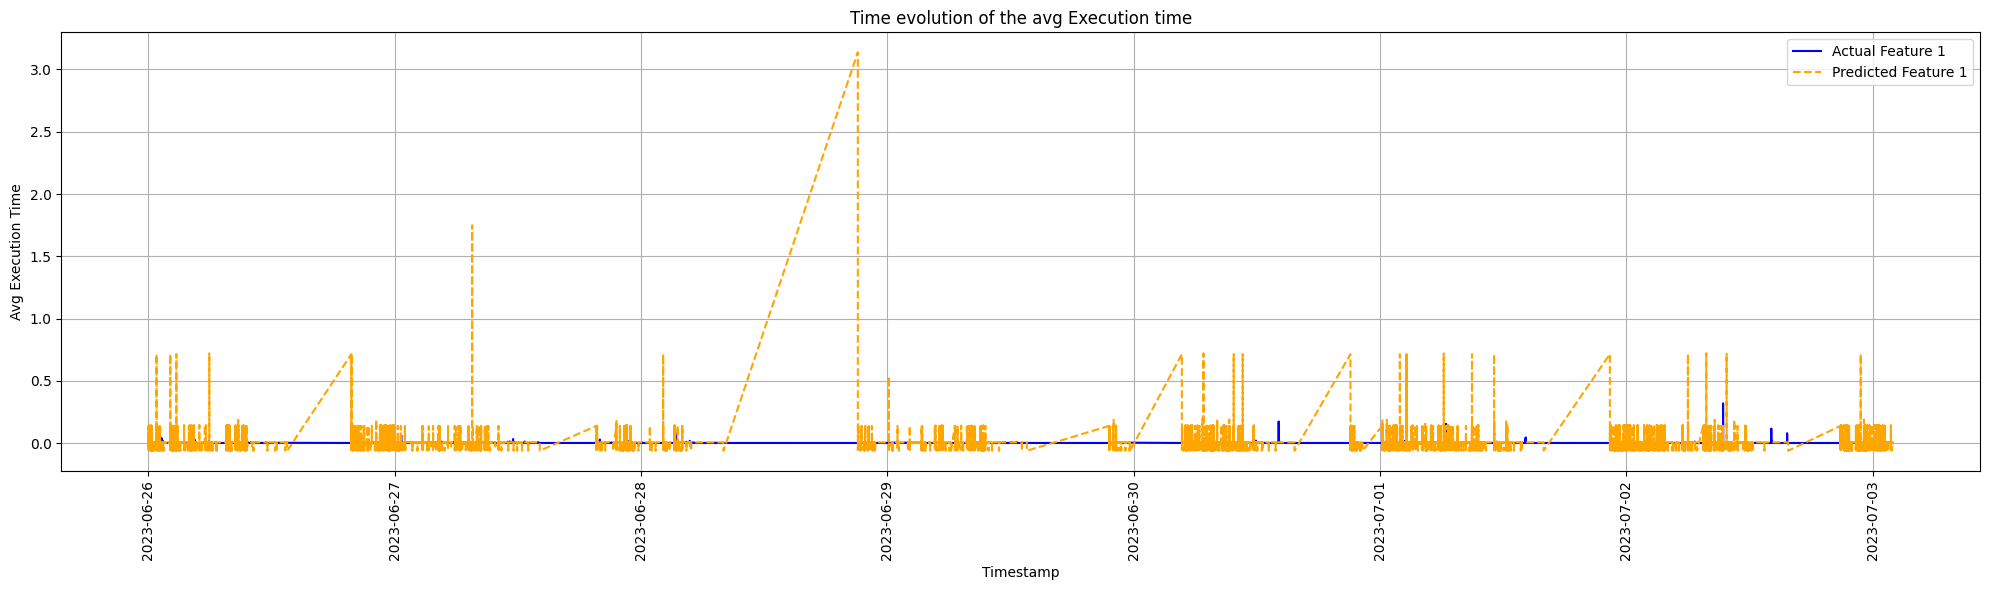

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico
plt.figure(figsize=(20, 6))
plt.plot(timestamps, first_values_actual, label='Actual Feature 1', color='blue')
plt.plot(timestamps, first_values_pred, label='Predicted Feature 1', linestyle='dashed', color='orange')

# Personalizzazione del grafico
plt.title("Time evolution of the avg Execution time")
plt.xlabel("Timestamp")
plt.ylabel("Avg Execution Time")
plt.xticks(rotation=90)  # Rotazione dei timestamp per leggibilità
plt.legend()
plt.grid()
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()


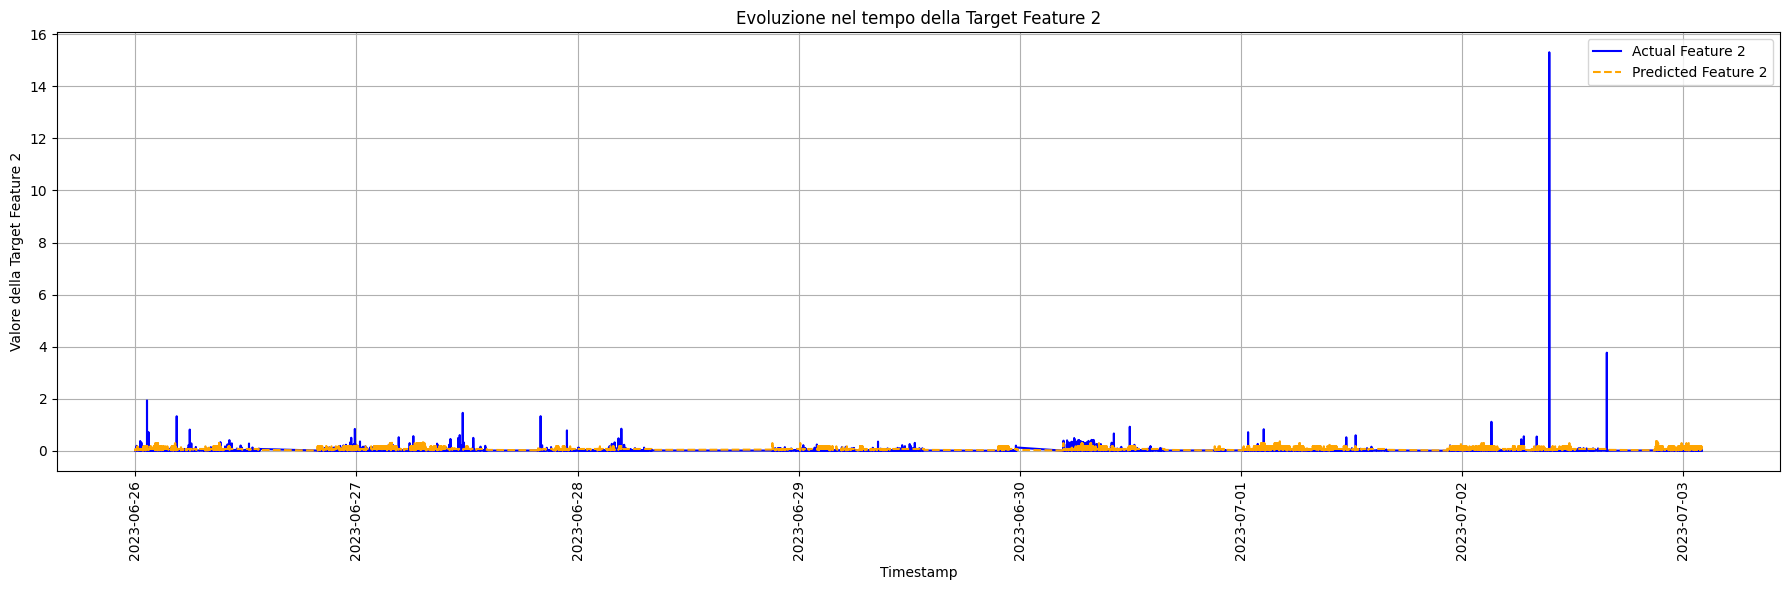

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Grafico
plt.figure(figsize=(18, 6))
plt.plot(timestamps, first_values_actual2, label='Actual Feature 2', color='blue')
plt.plot(timestamps, first_values_pred2, label='Predicted Feature 2', linestyle='dashed', color='orange')

# Personalizzazione del grafico
plt.title("Evoluzione nel tempo della Target Feature 2")
plt.xlabel("Timestamp")
plt.ylabel("Valore della Target Feature 2")
plt.xticks(rotation=90)  # Rotazione dei timestamp per leggibilità
plt.legend()
plt.grid()
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()

### ARMA MODELS

In [4]:
from datasets import load_dataset
data = load_dataset("anastasiafrosted/endpoint0", download_mode="force_redownload")
train = pd.DataFrame(data['train'])
test = pd.DataFrame(data['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/105M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/7.38M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/493508 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/34772 [00:00<?, ? examples/s]

In [5]:
df = pd.concat([train, test], ignore_index=True)

df['timestamp'] = df['timestamp'].str[:-9]
steps = df['timestamp']
# Step 1: Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.')
df = df.dropna()
df = df.sort_values("timestamp").set_index('timestamp')
df = df.drop("endpoint_uuid", axis=1)
df = df.dropna()
df.tail()

,invocations_per_hour,avg_loc,avg_cyc_complexity,avg_num_of_imports,avg_argument_size,e_type_LSFProvider,e_type_CobaltProvider,e_type_PBSProProvider,e_type_LocalProvider,e_type_KubernetesProvider,e_type_SlurmProvider,avg_total_execution_time,avg_system_processing_time
timestamp,,,,,,,,,,,,,
2023-07-03 01:59:29,2.95336,5.078649,5.21208,3.00032,1.207356,0,0,0,1,0,0,0.002072,0.010622
2023-07-03 01:59:41,2.95336,5.078649,5.21208,3.00032,1.207356,0,0,0,1,0,0,0.002177,0.017708
2023-07-03 01:59:54,2.95336,5.078649,5.21208,3.00032,1.207356,0,0,0,1,0,0,0.002235,0.018598
2023-07-03 01:59:55,2.95336,5.078649,5.21208,3.00032,1.207356,0,0,0,1,0,0,0.002065,0.012399
2023-07-03 01:59:57,2.95336,5.078649,5.21208,3.00032,1.207356,0,0,0,1,0,0,0.002114,0.014786


#### seasonality?

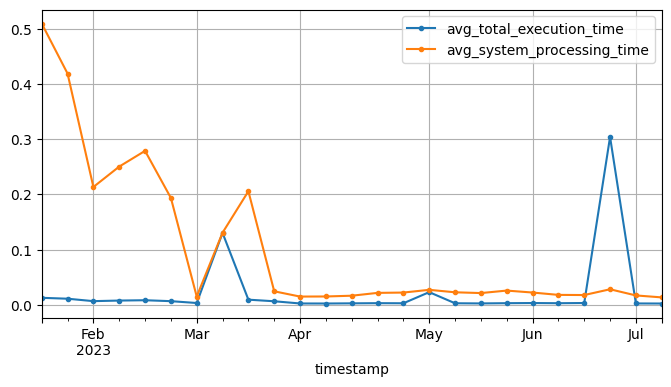

In [7]:
# seasonality, probably none
period = slice("2022", "2024")
df_weekly = df[["avg_total_execution_time", "avg_system_processing_time"]].resample('W').mean()  # compute the mean for each week
rolling_average_weeks = df_weekly[period].rolling(window=56).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_weekly[period].plot(ax=ax, marker=".")
rolling_average_weeks.plot(ax=ax, grid=True, legend=False)
#save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

#### Irregularly sampled data

<ipython-input-77-589c62f74e46>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt['timestamp'] = pd.to_datetime(dt['timestamp'])


Variance: 693619.1118580886


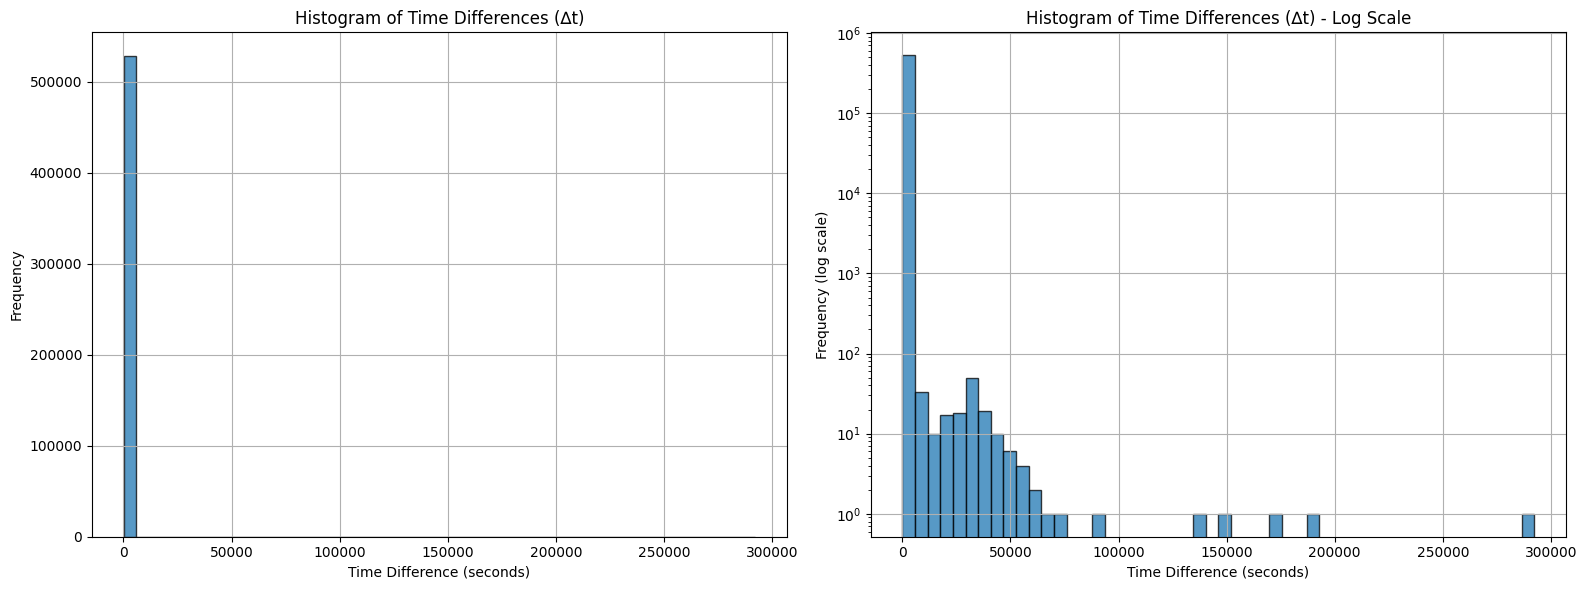

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Example dataset: Replace with your actual time series data
# Assuming a DataFrame `df` with a datetime column named 'timestamp'
dt = pd.DataFrame(steps)
dt['timestamp'] = pd.to_datetime(dt['timestamp'])

# Calculate time differences (∆t) in seconds
dt['dt'] = dt['timestamp'].diff().dt.total_seconds()

# Drop NaN resulting from the first difference
dt = dt.dropna()
filtered_df = dt['dt']    #dt[dt['dt'] > 50000]
# Calculate variance
variance_dt = filtered_df.var()
print(f"Variance: {variance_dt}")

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot the original histogram
axes[0].hist(filtered_df, bins=50, alpha=0.75, edgecolor='black')
axes[0].set_title('Histogram of Time Differences (∆t)')
axes[0].set_xlabel('Time Difference (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the log-scaled histogram
axes[1].hist(filtered_df, bins=50, alpha=0.75, edgecolor='black', log=True)
axes[1].set_title('Histogram of Time Differences (∆t) - Log Scale')
axes[1].set_xlabel('Time Difference (seconds)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

#### interpolate

In [7]:
origin, start_date, end_date = "2022-12-20 00:00:00", "2023-01-06 00:00:00", "2023-07-03 23:00:00"
time_period = pd.date_range(start_date, end_date, freq = 's')
# Interpolate missing values using 'time' method
df = df.asfreq('s').interpolate(method='time')

time_series_execution_time = df.loc[origin:end_date]["avg_total_execution_time"]
time_series_execution_time = time_series_execution_time.dropna()

time_series_processing_time = df.loc[origin:end_date]["avg_system_processing_time"]
time_series_processing_time = time_series_processing_time.dropna()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

y_preds_exe = []
y_preds_proc = []
# Iterate over each date in the time period
for today in time_period.shift(-1):
    # Ensure we use only the last 7 observations for training
    train_exe = time_series_execution_time.loc[:today].iloc[-7:]  # Last 7 values
    train_proc = time_series_processing_time.loc[:today].iloc[-7:]  # Last 7 values

    # Train and forecast for execution time
    model = ARIMA(train_exe, order=(0, 0, 0), enforce_stationarity=False)
    model = model.fit()
    y_pred = model.forecast(steps=1, index=[today])
    y_preds_exe.append(y_pred.iloc[0])  # Append prediction with timestamp

    # Train and forecast for processing time
    model = ARIMA(train_proc, order=(0, 0, 0), enforce_stationarity=False)
    model = model.fit()
    y_pred = model.forecast(steps=1, index=[today])
    y_preds_proc.append(y_pred.iloc[0])  # Append prediction with timestamp


#### models

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Take all the rows up until the last 100 values
exog_features = df[["invocations_per_hour", "avg_loc", "avg_cyc_complexity", "avg_num_of_imports", "avg_argument_size",
                   "e_type_LSFProvider", "e_type_CobaltProvider", "e_type_PBSProProvider","e_type_LocalProvider", "e_type_KubernetesProvider", "e_type_SlurmProvider"]].iloc[1000:-100]
target_1 = df["avg_total_execution_time"].iloc[1000:-100]
target_2 = df["avg_system_processing_time"].iloc[1000:-100]


# Fit SARIMAX model
model_1 = SARIMAX(target_1, exog=exog_features, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False)
fit_model_1 = model_1.fit(disp=False)
# Forecast the next 7 steps
forecast_1 = fit_model_1.forecast(steps=7, exog=df["avg_total_execution_time"].iloc[-100:])


# Fit SARIMAX model
model_2 = SARIMAX(target_2, exog=exog_features, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False)
fit_model_2 = model_2.fit(disp=False)
# Forecast the next 7 steps
forecast_2 = fit_model_2.forecast(steps=7, exog=df["avg_system_processing_time"].iloc[-100:])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Historical data (actual values)
historical_values = target_1  # Replace with your actual target variable data

# Forecasted values (predictions for the next 7 steps)
forecast_steps = 7
forecast_values = forecast_1  # Replace with your forecast
forecast_index = pd.date_range(start=historical_values.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq="D")

# Create a forecast series
forecast_series = pd.Series(forecast_values, index=forecast_index)

# Plot the historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(historical_values, label="Historical Values", color="blue")
plt.plot(forecast_series, label="Forecasted Values", color="orange", linestyle="--")
plt.axvline(x=forecast_index[0], color="gray", linestyle="--", label="Forecast Start")  # Mark forecast start

# Add labels, title, and legend
plt.title("Target 1 Forecasts vs Historical Values", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [ ]:
# extra code – displays the SARIMA forecasts
y_preds_exe_values = [float(pred[1]) for pred in y_preds_exe]
y_preds_exe = pd.Series(
    data=[pred for _, pred in y_preds_exe],  # Extract predictions
    index=[timestamp for timestamp, _ in y_preds_exe],  # Extract timestamps
)
fig, ax = plt.subplots(figsize=(20, 7))
time_series_execution_time.plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds_exe, color="r", marker=".", label="ARIMA Forecasts")
plt.legend()
plt.show()

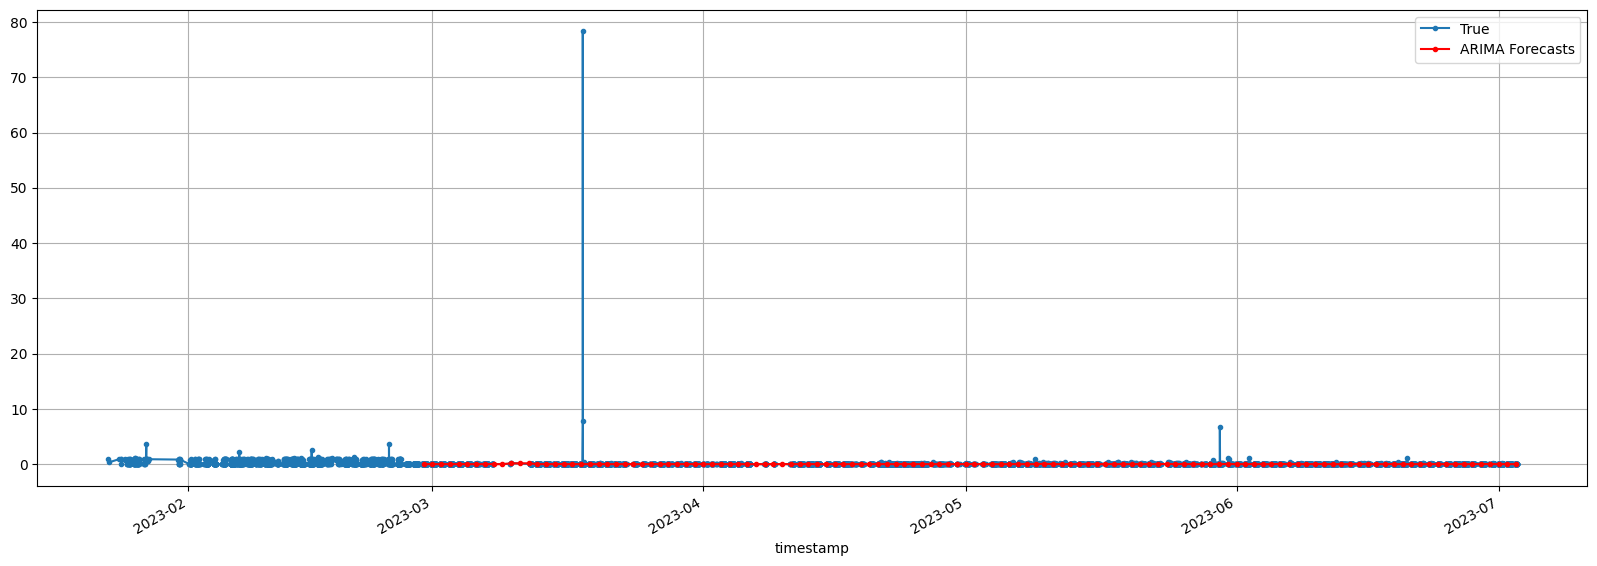

In [23]:
# extra code – displays the SARIMA forecasts
y_preds_proc_values = [float(pred[1]) for pred in y_preds_proc]
y_preds_proc = pd.Series(
        data=[pred for _, pred in y_preds_proc],  # Extract predictions
    index=[timestamp for timestamp, _ in y_preds_proc],  # Extract timestamps
)
fig, ax = plt.subplots(figsize=(20, 7))
time_series_processing_time.plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds_proc, color="r", marker=".", label="ARIMA Forecasts")
plt.legend()
plt.show()

#### THIS DATA NEEDS TO BE RESCALED

In [178]:
print(len(time_series_processing_time[start_date:today].asfreq("h").dropna().values))

133


In [171]:
# Save predictions to a CSV file
output_df = pd.DataFrame({
    "timestamp": time_series_execution_time[start_date:today].asfreq("h").dropna().index,
    "actual_execution_time" : time_series_execution_time[start_date:today].asfreq("h").dropna().values,
    "predicted_execution_time": y_preds_exe_values,
    "actual_system_processing_time" : time_series_processing_time[start_date:today].asfreq("h").dropna().values,
    "predicted_system_processing_time": y_preds_proc_values
})
print(output_df.tail())

ValueError: All arrays must be of the same length

In [80]:
# Save the updated DataFrame back to the same CSV file
output_df.to_csv("centralized_arima_predictions.csv", index=False)